# Market Implied Probability Comparisons

The purpose of this notebook is to investigate the best way to convert the advertised odds to market-implied probabilities. We want to find the best way to remove the bookmaker/betfair's margin, aiming to correct for bookmaker bias and overround while capturing favorite–longshot bias.

We compare the following methods:
+ Multiplicative margin removal
+ Odds ratio margin removal
+ Shin's z score
+ Power margin removal

I found these methods in the paper: https://arxiv.org/pdf/2112.13001

In [ ]:
import pandas as pd

ds = pd.read_csv("data/preprocessed_raceform_with_topic_features.csv", low_memory=False)

## Multiplicative margin removal

The multiplicative margin removal method, also known as basic method, normalise the inverse odds proportionally and divided by its booksum π.

In [4]:
# Multiplicative margin removal
ds["mm_win_prob"] = ds.groupby("race_id")["sp"].transform(lambda x: (1 / x) / (1 / x).sum()).clip(1e-12, 1 - 1e-12)

# Odds ratio margin removal
The odds ratio margin removal method fixes the ratio between the implied probability and the raw probability with margin π on all possible outcomes.

In [9]:
import numpy as np
from scipy.optimize import brentq

def odds_ratio_implied_probs(odds, tol=1e-12):
    """
    Remove margin using the odds ratio method (Lindstrøm 2021 implied R package).
    
    Parameters:
        odds : array-like of decimal odds for each outcome
        tol : tolerance for root-finding
        
    Returns:
        fair_probs : numpy array of fair implied probabilities summing to 1
    """
    pi = np.array([1.0 / o for o in odds])
    # Define function for solving: sum(pi_i / (λ + π_i)) - 1 = 0
    def func(lmbda):
        return np.sum(pi / (lmbda + pi)) - 1.0
    
    # Find bounds: λ must be > –min(pi), start safe interval
    lower = 0.0
    upper = max(pi) * 1000
    
    # Solve λ
    lam = brentq(func, lower, upper, xtol=tol)
    
    fair = pi / (lam + pi)
    return fair

ds["orm_win_prob"] = ds.groupby("race_id")["sp"].transform(odds_ratio_implied_probs).clip(1e-12, 1 - 1e-12)

## Shin's z score

Shin’s method handles the information asymmetry for bookmakers as less informed price-setters who face a group of insiders with superior information.

In [12]:
def shin_probabilities(odds, tol=1e-12, verbose=False):
    """
    Calculate fair probabilities using Shin's method, with fallback to naive normalization.

    Parameters:
        odds : list or array-like of decimal odds
        tol : float, numerical solver tolerance
        verbose : bool, print messages if fallback is used

    Returns:
        fair_probs : np.array of fair implied probabilities summing to 1
    """
    odds = np.array(odds)
    pi = 1.0 / odds

    def f(z):
        if z <= 0 or z >= 1:
            return 1.0
        return np.sum((np.sqrt(z**2 + 4 * (1 - z) * pi) - z) / 2) - 1

    try:
        # Evaluate bounds to ensure root is bracketed
        f_low = f(1e-6)
        f_high = f(1 - 1e-6)

        if f_low * f_high > 0:
            raise ValueError("Function values at bounds do not bracket a root.")

        # Solve for z using brentq
        z = brentq(f, 1e-6, 1 - 1e-6, xtol=tol)

        # Compute fair probabilities using Shin's formula
        fair_probs = (np.sqrt(z**2 + 4 * (1 - z) * pi) - z) / 2
        return fair_probs

    except Exception as e:
        if verbose:
            print(f"[Fallback] Shin root-finding failed: {e}. Using naive normalization.")
        fair_probs = pi / pi.sum()
        z = 0
        return fair_probs


ds["shin_win_prob"] = ds.groupby("race_id")["sp"].transform(shin_probabilities).clip(1e-12, 1 - 1e-12)

## Power margin removal

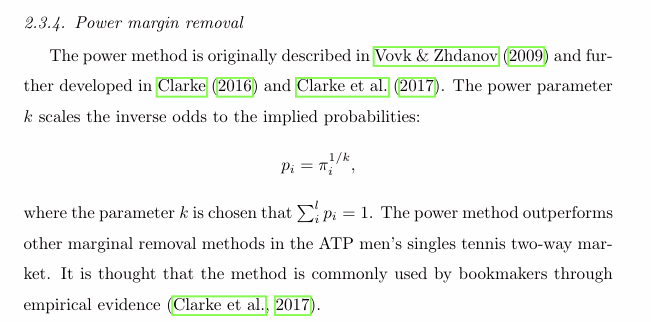

In [15]:
def power_margin_removal(odds, tol=1e-12, target_sum=1.0, verbose=False):
    """
    Apply Power Margin Removal to a set of decimal odds.

    Parameters:
        odds : list or array of decimal odds
        tol : float, numerical tolerance
        target_sum : float, sum of adjusted probabilities (usually 1.0)
        verbose : bool, print messages if fallback used

    Returns:
        fair_probs : np.array of fair probabilities summing to `target_sum`
        alpha : power parameter used for adjustment
    """
    odds = np.array(odds)
    raw_probs = 1 / odds

    def f(alpha):
        powered = raw_probs ** alpha
        return powered.sum() - target_sum

    try:
        # Try to find alpha in a reasonable interval (0.01 to 2)
        alpha = brentq(f, 0.01, 10, xtol=tol)

        fair_probs = (raw_probs ** alpha) / np.sum(raw_probs ** alpha)
        return fair_probs

    except Exception as e:
        if verbose:
            print(f"[Fallback] Power method failed: {e}. Using naive normalization.")
        return raw_probs / raw_probs.sum()

ds["power_win_prob"] = ds.groupby("race_id")["sp"].transform(power_margin_removal).clip(1e-12, 1 - 1e-12)

# Comparison using logistic regression

We fit logistic regression models to evaluate each methods performance.

In [20]:
from sklearn.linear_model import LogisticRegression

ds["logit_mm_win_prob"] = np.log(ds["mm_win_prob"] / (1 - ds["mm_win_prob"]))
ds["logit_orm_win_prob"] = np.log(ds["orm_win_prob"] / (1 - ds["orm_win_prob"]))
ds["logit_shin_win_prob"] = np.log(ds["shin_win_prob"] / (1 - ds["shin_win_prob"]))
ds["logit_power_win_prob"] = np.log(ds["power_win_prob"] / (1 - ds["power_win_prob"]))

train_mask = ds["train_val_test_split"] == "train"
y_train = ds.loc[train_mask, "is_winner"].values


ds["ones"] = np.ones((len(ds), 1))
uniform_colnames = ["ones"]
X_train = ds.loc[train_mask, uniform_colnames].values
uniform_model = LogisticRegression(fit_intercept=False)
uniform_model.fit(X_train, y_train)

mm_colnames = ["logit_mm_win_prob"]
X_train = ds.loc[train_mask, mm_colnames].values
mm_model = LogisticRegression()
mm_model.fit(X_train, y_train)

orm_colnames = ["logit_orm_win_prob"]
X_train = ds.loc[train_mask, orm_colnames].values
orm_model = LogisticRegression()
orm_model.fit(X_train, y_train)

shin_colnames = ["logit_shin_win_prob"]
X_train = ds.loc[train_mask, shin_colnames].values
shin_model = LogisticRegression()
shin_model.fit(X_train, y_train)

power_colnames = ["logit_power_win_prob"]
X_train = ds.loc[train_mask, power_colnames].values
power_model = LogisticRegression()
power_model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [29]:
from scipy.stats import norm

def one_sided_test_model_a_better(
    model_a, features_a,
    model_b, features_b,
    ds,
    split_col="train_val_test_split",
    split_name="test",
    alpha=0.05
):
    mask = ds[split_col] == split_name
    dt = ds.loc[mask].copy()

    Xa = dt[features_a].to_numpy()
    Xb = dt[features_b].to_numpy()

    dt["prob_a"] = model_a.predict_proba(Xa)[:, 1]
    dt["prob_b"] = model_b.predict_proba(Xb)[:, 1]

    dt["prob_a"] /= dt.groupby("race_id")["prob_a"].transform("sum")
    dt["prob_b"] /= dt.groupby("race_id")["prob_b"].transform("sum")

    winners = dt[dt["is_winner"] == 1]
    p_a = winners["prob_a"].to_numpy()
    p_b = winners["prob_b"].to_numpy()

    log_ratios = np.log(np.clip(p_a, 1e-12, 1 - 1e-12)) - np.log(np.clip(p_b, 1e-12, 1 - 1e-12))
    mean_diff = -np.mean(log_ratios)
    se = np.std(log_ratios, ddof=1) / np.sqrt(len(log_ratios))

    z_stat = mean_diff / se
    p_value = norm.cdf(z_stat)

    reject_null = p_value < alpha

    return {
        "mean_logscore_diff": mean_diff,
        "standard_error": se,
        "z_statistic": z_stat,
        "p_value": p_value,
        "alpha": alpha,
        "reject_null": reject_null
    }

results1 = one_sided_test_model_a_better(mm_model, mm_colnames, uniform_model, uniform_colnames, ds, split_name="val")
results2 = one_sided_test_model_a_better(orm_model, orm_colnames, uniform_model, uniform_colnames, ds, split_name="val")
results3 = one_sided_test_model_a_better(shin_model, shin_colnames, uniform_model, uniform_colnames, ds, split_name="val")
results4 = one_sided_test_model_a_better(power_model, power_colnames, uniform_model, uniform_colnames, ds, split_name="val")
pd.DataFrame([results1, results2, results3, results4])

,mean_logscore_diff,standard_error,z_statistic,p_value,alpha,reject_null
0,-0.407766,0.003655,-111.558588,0.0,0.05,True
1,-0.404557,0.003532,-114.550539,0.0,0.05,True
2,-0.404979,0.003494,-115.894093,0.0,0.05,True
3,-0.407775,0.003757,-108.527885,0.0,0.05,True


In [30]:
print(mm_model.intercept_, mm_model.coef_)
print(orm_model.intercept_, orm_model.coef_)
print(shin_model.intercept_, shin_model.coef_)
print(power_model.intercept_, power_model.coef_)

[0.21155564] [[1.11567455]]
[0.47867055] [[1.26243371]]
[0.54388466] [[1.29659176]]
[0.03932921] [[1.01961772]]


The conclusion is that there is not much difference betweem the methods, however the best methods are the multiplicative method and the power method. Looking at the coefficients however, it seems that the power method may be best to use, since the intercept is close to 0 and the coefficient of the logit odds are close to 1.